# Uncertainty quantification for cross sections
This tutorial will demonstrate how to use jitr to perform uncertainty quantification of a simple reaction observable: differential elastic scattering cross sections. We will use the uncertainty quantified optical potential KDUQ introduced here: [[Pruitt et al., 2024]](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602). Jitr includes an implementation of the kduq potential, as well as a set of samples of the posterior provided in the supplemental material of that paper.

In [1]:
from pathlib import Path

import corner

# import stuff for nice plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from numba import njit
from scipy import stats
from tqdm import tqdm

import jitr

We will use [exfor-tools](https://github.com/beykyle/exfor_tools) using an [x4i3](https://github.com/afedynitch/x4i3/) backend for grabbing data from [EXFOR](https://www-nds.iaea.org/exfor/) (requires 1GB of disk space to download).

In [2]:
#! pip install exfor-tools
import exfor_tools

Using database version x4i3_X4-2023-04-29 located in: /home/beyerk/mambaforge/envs/sage/lib/python3.11/site-packages/x4i3/data


### Let's find some data to compare to
Let's grab some data from [EXFOR](https://www-nds.iaea.org/exfor/). We will look at $d\sigma_{el}/d\Omega$ for $(n,n)$ and $(p,p)$.

In [3]:
# target to consider
Pb208 = (208, 82)
proton = (1, 1)
neutron = (1, 0)

# for plotting differential xs
angles = np.linspace(0.1, np.pi, 100)

### Let's start with neutrons

In [4]:
# we have 416 samples from the KDUQ posterior
num_samples_kduq = 415
param_files = [
    Path(f"./../../src/data/KDUQFederal/{i}/parameters.json")
    for i in range(0, num_samples_kduq)
]

# load each one
kduq_omps = [
    jitr.reactions.kduq.KDGlobal(neutron, Path(param_file))
    for param_file in param_files
]

In [5]:
all_entries = exfor_tools.get_exfor_differential_data(
    target=Pb208,
    projectile=(1, 0),
    quantity="dXS/dA",
    product="EL",
    energy_range=[7, 20],  # MeV
)
all_measurements = exfor_tools.sort_measurements_by_energy(all_entries)
print(
    f"Found measurements at {len(list(all_entries))} different energies for (n,n) on 208-Pb"
)

Found measurements at 9 different energies for (n,n) on 208-Pb


In [6]:
all_entries.keys()

dict_keys(['10412', '10871', '12903', '12935', '13531', '13635', '13685', '22121', '40288'])

In [7]:
all_entries_Ay = exfor_tools.get_exfor_differential_data(
    target=Pb208,
    projectile=(1, 0),
    quantity="Ay",
    product="EL",
    energy_range=[7, 20],  # MeV
)
all_measurements_Ay = exfor_tools.sort_measurements_by_energy(all_entries_Ay)
print(
    f"Found measurements at {len(list(all_entries_Ay))} different energies for (n,n) on 208-Pb"
)

There was an error reading entry 12859, it will be skipped:
Missing 'Data' field!
There was an error reading entry 13531, it will be skipped:
Missing 'Data' field!
There was an error reading entry 22121, it will be skipped:
Missing 'Angle' field!
There was an error reading entry 40075, it will be skipped:
Missing 'Angle' field!
Found measurements at 6 different energies for (n,n) on 208-Pb


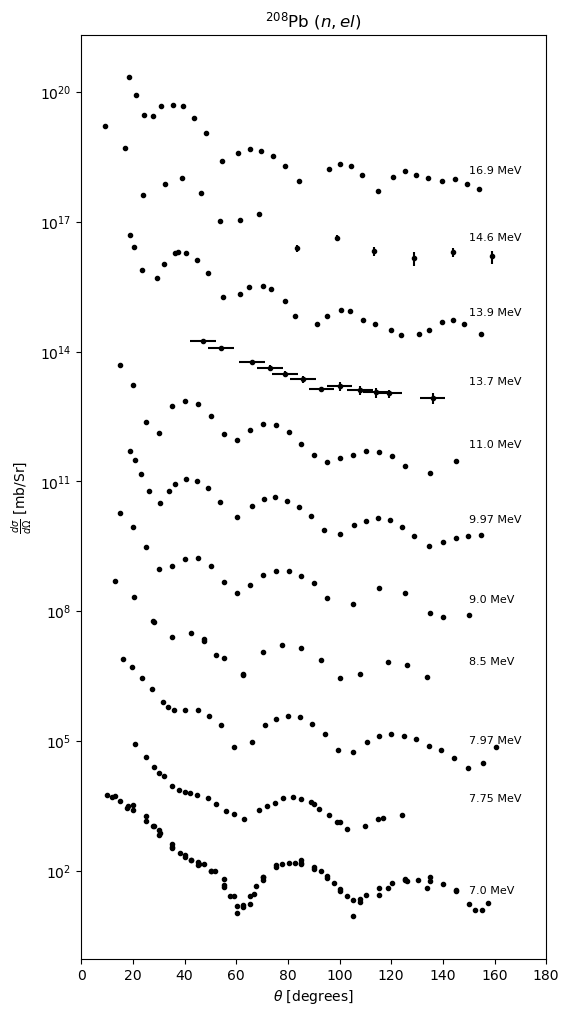

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
exfor_keys = list(all_entries.keys())
all_entries[exfor_keys[0]].plot_experiment(
    ax,
    all_measurements,
    offsets=50,
    label_offset_factor=2,
    label_hloc_deg=150,
    label_energy_err=False,
    label_offset=False,
)

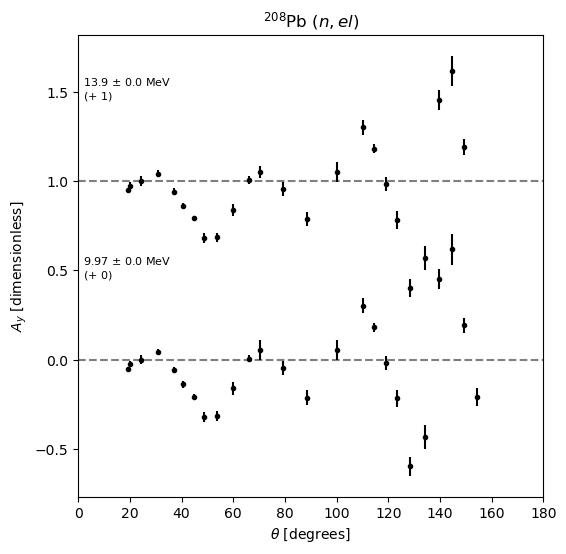

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
exfor_keys = list(all_entries_Ay.keys())
all_entries_Ay[exfor_keys[0]].plot_experiment(
    ax,
    offsets=1,
    log=False,
    label_offset_factor=0.5,
    label_hloc_deg=2,
    add_baseline=True,
)

### Let's set up our solver to calculate $^{208}$Pb $(n,n)$ differential cross sections

We will use the the KDUQ potential from [Pruitt et al., 2024](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602) potential. The supplemental material in that link contains a set of samples from the posterior of the KDUQ parameter distribution. Let's load them up:

In [10]:
core_solver = jitr.rmatrix.Solver(40)

In [11]:
lab_energies = []
kduq_solvers = []

for measurement in all_measurements:
    Elab = measurement.Elab

    # get kinematics and parameters for this experiment
    sys = jitr.reactions.ProjectileTargetSystem(
        channel_radius=10 * np.pi,
        lmax=20,
        mass_target=jitr.utils.kinematics.mass(*Pb208),
        mass_projectile=jitr.utils.kinematics.mass(*neutron),
        Ztarget=Pb208[1],
        Zproj=neutron[1],
        coupling=jitr.reactions.system.spin_half_orbit_coupling,
    )

    # get kinematics and parameters for this experiment
    kinematics = jitr.utils.kinematics.classical_kinematics(
        sys.mass_target, sys.mass_projectile, Elab, sys.Zproj * sys.Ztarget
    )
    lab_energies.append(Elab)

    kduq_solvers.append(
        jitr.xs.elastic.DifferentialWorkspace.build_from_system(
            projectile=neutron,
            target=Pb208,
            sys=sys,
            kinematics=kinematics,
            solver=core_solver,
            angles=angles,
        )
    )

Now that we have the solvers set up, let's run the UQ!

In [12]:
num_samples_pred_post = 100
kduq_pred_post = []
kduq_pred_post_Ay = []

for i, measurement in enumerate(all_measurements):
    # get a differential xs for each parameter sample
    kduq_xs = np.zeros((len(angles), num_samples_pred_post))
    kduq_ay = np.zeros((len(angles), num_samples_pred_post))

    samples = np.random.choice(num_samples_kduq, size=num_samples_pred_post)

    for j, sample in enumerate(tqdm(samples)):
        omp = kduq_omps[sample]
        coulomb_params, scalar_params, spin_orbit_params = omp.get_params(
            *Pb208, kinematics.mu, lab_energies[i], kinematics.k
        )
        xs = kduq_solvers[i].xs(
            jitr.reactions.KD_scalar,
            jitr.reactions.KD_spin_orbit,
            scalar_params,
            spin_orbit_params,
        )
        kduq_xs[:, j] = xs.dsdo
        kduq_ay[:, j] = xs.Ay

    # get credible intervals describing the KDUQ predictive posterior
    # for this experiment
    kduq_pred_post.append(
        (
            np.percentile(kduq_xs, 5, axis=1),
            np.percentile(kduq_xs, 95, axis=1),
        )
    )
    kduq_pred_post_Ay.append(
        (
            np.percentile(kduq_ay, 5, axis=1),
            np.percentile(kduq_ay, 95, axis=1),
        )
    )

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 294.23it/s]


Now that we have our model predictions, lets plot them compared to the experimental data. We will offset each energy for visibility.

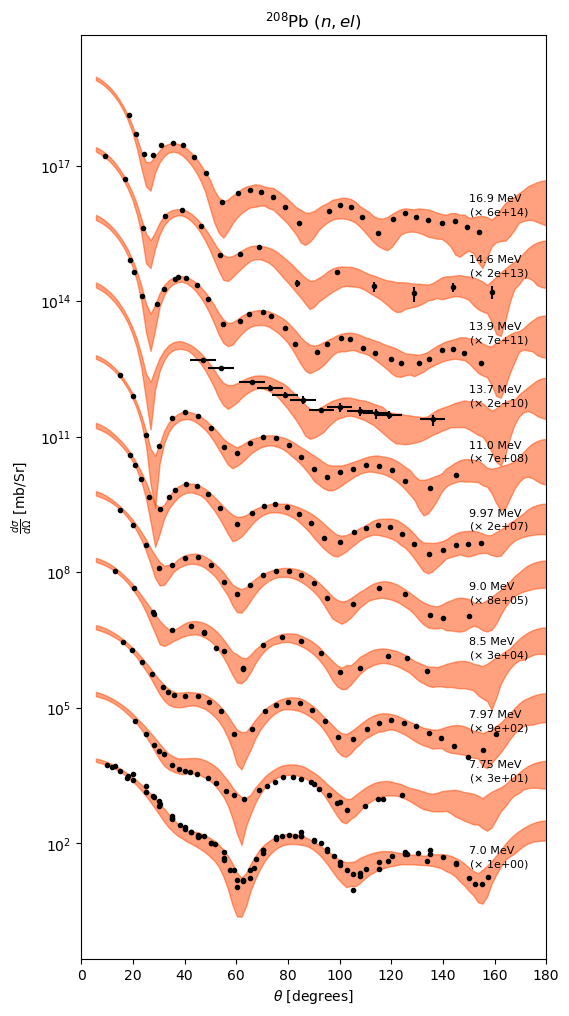

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
exfor_keys = list(all_entries.keys())
all_entries[exfor_keys[0]].plot_experiment(
    ax,
    all_measurements,
    offsets=30,
    label_offset_factor=2,
    label_hloc_deg=150,
    label_energy_err=False,
    label_offset=True,
)
offsets = 30 ** np.arange(len(all_measurements))
for i in range(len(all_measurements)):
    # plot model
    ax.fill_between(
        angles * 180 / np.pi,
        offsets[i] * kduq_pred_post[i][0],
        offsets[i] * kduq_pred_post[i][1],
        color="#ff4500",
        alpha=0.5,
    )

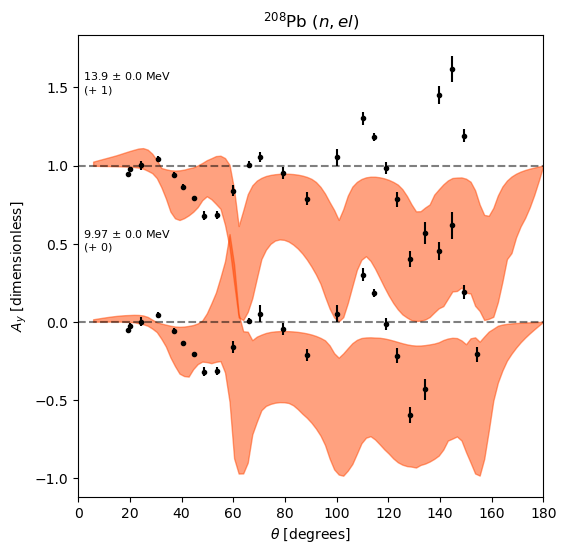

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
exfor_keys = list(all_entries_Ay.keys())
all_entries_Ay[exfor_keys[0]].plot_experiment(
    ax,
    offsets=1,
    log=False,
    label_offset_factor=0.5,
    label_hloc_deg=2,
    add_baseline=True,
)
offsets = [0, 1]
for i in range(len(all_measurements_Ay)):
    # plot model
    ax.fill_between(
        angles * 180 / np.pi,
        offsets[i] + kduq_pred_post_Ay[i][0],
        offsets[i] + kduq_pred_post_Ay[i][1],
        color="#ff4500",
        alpha=0.5,
    )